Read necessary libraries 

In [1]:
from matplotlib import pyplot as plt, rcParams, animation
import scipy, seaborn as sns, matplotlib
from scipy.cluster import hierarchy as hc
matplotlib.rc('animation', html='html5')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=5, linewidth=110, suppress=True)
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import ben

In [2]:
path = 'data/thesis/'

### I. Data

1. 12 industry ETFs, each industry ETF is a column in a dataframe called "ind", these ETFs are designed by BlackRock
2. 07 factor ETFs representing factor investing, each strategy is a column in a dataframe called "factor", these ETFs are designed by BlackRock
3. S&P500 as market index and risk free rate (T-Bill one-month return) as rf

In [3]:
ind = ben.get_df('sector_return.xlsx', path); ind.head(2)

,IDU,IYC,IYF,IYG,IYH,IYJ,IYK,IYM,IYR,IYT,IYW,IYZ
Date,,,,,,,,,,,,
2013-08,-0.053026,-0.037844,-0.049613,-0.051423,-0.035187,-0.022068,-0.033417,-0.001690,-0.065325,-0.032828,-0.006214,-0.040458
2013-09,0.005246,0.054969,0.028347,0.024893,0.028868,0.052925,0.021505,0.043441,0.024904,0.053466,0.026443,0.029104


In [4]:
ind.shape

(89, 12)

In [5]:
factor = ben.get_df('factor_return.xlsx', path); factor.head(2)

,EEMV,EFAV,MTUM,QUAL,SIZE,USMV,VLUE
Date,,,,,,,
2013-08,-0.040745,-0.017007,-0.035704,-0.020750,-0.033024,-0.032573,-0.031201
2013-09,0.065892,0.054481,0.030237,0.038127,0.031530,0.025530,0.028047


In [6]:
factor.shape

(89, 7)

In [7]:
market_rf = ben.get_df_excel('sp500.xlsx', path); market_rf.head(2)
market_rf.columns = ['rf','sp500']
market_rf.head(2)

,rf,sp500
Date,,
2013-08,0.000009,-0.031298
2013-09,0.000008,0.029749


In [8]:
market_rf.shape

(89, 2)

In [12]:
mar_ret = market_rf['sp500'].mean()
mar_vol = market_rf['sp500'].std()
market = (mar_ret, mar_vol)
market

(0.009845607748314607, 0.04023132413238701)

In [13]:
rf = market_rf['rf'].mean()
rf

0.0005907303370786517

### II. Descriptive statistics

In [63]:
l = ["Sharpe ratio", "Skewness", "Kurtosis", "VaR", "annu. return"]
func_name = [ben.sharpe_ratio, ben.get_skewness, ben.get_kurtosis, ben.var_historic, 
             ben.annualize_ret]

In [64]:
def get_descriptive (df, l, func_name):
    des = df.describe()
    for i in range(0, len(l)):
        row_name = l[i]
        func = func_name[i]
        if row_name == "Sharpe ratio":
            row_val = func(df, rf).values
        else:
            row_val = func(df).values
        des.loc[-1] = row_val
        des.rename(index={-1: row_name}, inplace=True)
    return des

In [65]:
ind_col = ['Utilities','Consumer','Financials','Fin. Services',
        'Healthcare','Industrials','Con. Staples','Materials','Real Estate',
        'Transportation','Technology','Telecom']

In [66]:
fac_col = ['EM Min Vol','EAFE Min Vol','US Momentum','US Quality',
          'US Size','US Min Vol','US Value']

In [67]:
def mapping_column_name (df, col_name):
    res = {}
    for i in range(0, len(col_name)):
        o = df.columns[i]
        r = col_name[i]
        res[o] = r
    return res

---

In [68]:
ind_name = mapping_column_name(ind, ind_col)
ind_name

{'IDU': 'Utilities',
 'IYC': 'Consumer',
 'IYF': 'Financials',
 'IYG': 'Fin. Services',
 'IYH': 'Healthcare',
 'IYJ': 'Industrials',
 'IYK': 'Con. Staples',
 'IYM': 'Materials',
 'IYR': 'Real Estate',
 'IYT': 'Transportation',
 'IYW': 'Technology',
 'IYZ': 'Telecom'}

In [69]:
fac_name = mapping_column_name(factor, fac_col)
fac_name

{'EEMV': 'EM Min Vol',
 'EFAV': 'EAFE Min Vol',
 'MTUM': 'US Momentum',
 'QUAL': 'US Quality',
 'SIZE': 'US Size',
 'USMV': 'US Min Vol',
 'VLUE': 'US Value'}

In [70]:
ind_des = get_descriptive(ind, l, func_name)
ind_des.columns = ind_col
ind_des

,Utilities,Consumer,Financials,Fin. Services,Healthcare,Industrials,Con. Staples,Materials,Real Estate,Transportation,Technology,Telecom
count,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000
mean,0.000242,0.003190,0.001772,0.009381,0.010140,0.004413,0.008173,0.006772,0.003837,0.008810,0.009179,0.001801
std,0.066115,0.092505,0.069744,0.058649,0.040766,0.072140,0.041077,0.055106,0.044371,0.054617,0.094143,0.043159
min,-0.500868,-0.742240,-0.475615,-0.224605,-0.099103,-0.489512,-0.123958,-0.164818,-0.204005,-0.180762,-0.738336,-0.112183
25%,-0.019774,-0.012720,-0.021237,-0.020734,-0.009760,-0.020049,-0.015303,-0.022288,-0.016697,-0.011662,-0.017074,-0.025273
50%,0.012605,0.010803,0.017944,0.021254,0.010405,0.009759,0.006491,0.007687,0.005065,0.011699,0.021401,0.000310
75%,0.032318,0.034728,0.033936,0.038968,0.037505,0.035959,0.027978,0.035130,0.029183,0.041493,0.047152,0.027958
max,0.084260,0.155848,0.146394,0.177839,0.129286,0.156714,0.127564,0.171214,0.114758,0.118417,0.146240,0.119835
Sharpe ratio,-0.005274,0.028098,0.016937,0.149881,0.234241,0.052980,0.184586,0.112179,0.073169,0.150486,0.091223,0.028044
Skewness,-5.012742,-5.924199,-3.884567,-0.655885,-0.263935,-3.725537,-0.090281,-0.009428,-0.984885,-0.759845,-5.661164,0.237314


In [71]:
ind_des.to_excel(f'{path}industry_descriptive.xlsx') # export to excel

In [72]:
ind_des.to_latex(f'{path}ind_des.tex')

---

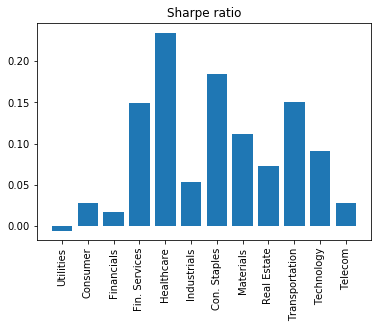

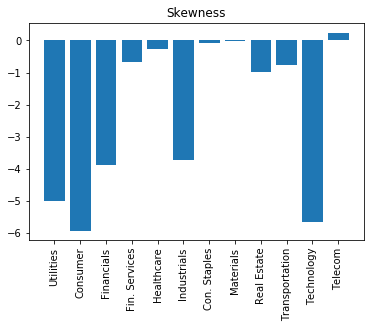

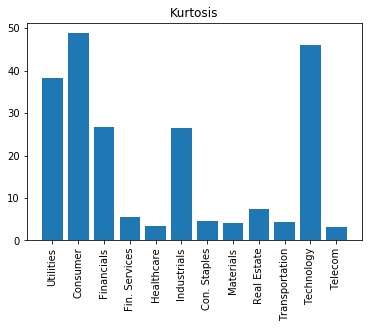

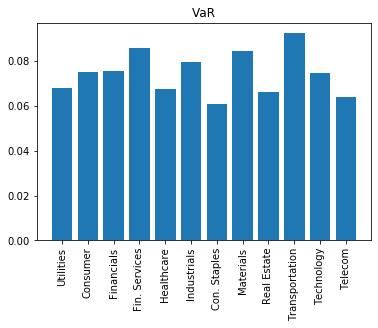

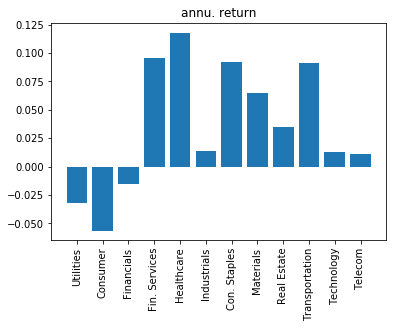

In [73]:
for i in range(0, len(l)):
    plt.figure()
    cri = l[i]
    plt.bar(ind_des.columns,ind_des.loc[cri])
    plt.title(f'{cri}')
    plt.xticks(rotation='vertical')

In [84]:
m = ben.annualize_ret(market_rf['sp500'])
m

0.11407396963666461

- Considered as one of the most cited ratio in measuring financial performance is the Sharpe ratio, first developed by William Sharpe (1966), which calculated the excess expected return over its volatility (standard deviation) of an investment. The higher the ratio, the better the investment. While the ratio for sector ETFs ranges from practically zero (Utilities) to 0.23 (Healthcare), the ratio for factor ETFs has higher spectrum, ranging from 0.07 (EM minimized volatility) to 0.33 (US momentum), indicating that on average, the factor ETFs earned more excess returns after adjusting for its risk.
- For skewness - a measure of symmetry in data distributions, all sector ETFs are negative, except Telecomunication (0.23), and they vary notably across industries. Factor ETFs have lower level of variability, from -0.8 (US Min Vol) to -0.28 (US Quality). The same pattern arises in terms of measuring statistical distributions by Kurtosis. A larger, wider Kurtosis range of sector ETFs, from 3.19 (Telecommunication) to 48.7 (Consumer), compared to the factor ETFs range (from 3.4 to 7.6), implies a higher level of risk associated with sector investments.
- As pointed out by Ang, Chen, and Xing (2006), investors pay more attention to downside risks, rather than the overall volatility. Specifically, the latter measures the variability of returns around the expected value, regardless of the sign. This is rarely the case in reality where "agents who place greater weight on the risk of downside losses than they are attach to upside gains demand greater compensation for holding stocks with high downside risk". In order to measure this downside risk, many methods have been proposed over the years, however Value at Risk (VaR) was considered as the most widely accepted approach. First developed by J.P. Morgan in 1996, VaR enabled investors to gauge the maximum estimated loss at a commonly 95% confident level. VaR in sector ETFs ranged from 0.064 (Telecommunication) to 0.092 (Transportation), which was greater than that of factor ETFs from 0.042 to 0.076, implying repeatedly the fact that an investment in sector ETFs was more presumably risky than in factor ETFs.
- Regarding annualized returns, there was three sector ETFs that lost money over the sample period (Utilities, Consumers, and Financials), whilst the best performing sectors belonged to Healthcare and Financial Services (approximately around 10%). As for factor ETFs, the lowest annualized return was 3.4% (EM Min Vol), while the US momentum ETF captured the highest return at 17.2%, followed by the US quality ETF at 14%.

Ang, Andrew and Chen, Joseph S. and Xing, Yuhang, Downside Risk (March 3, 2004). AFA 2005 Philadelphia Meetings, Available at SSRN: https://ssrn.com/abstract=641843 or http://dx.doi.org/10.2139/ssrn.641843

Glasserman, Paul and Heidelberger, Philip and Shahabuddin, Perwez, Portfolio Value-at-Risk with Heavy-Tailed Risk Factors. Available at SSRN: https://ssrn.com/abstract=316207

Sharpe, W.F. (1966) Mutual fund performance. The Journal of Business, 39, 119-138.
http://dx.doi.org/10.1086/294846


---

In [74]:
factor_des = get_descriptive(factor, l, func_name)
factor_des.columns = fac_col
factor_des

,EM Min Vol,EAFE Min Vol,US Momentum,US Quality,US Size,US Min Vol,US Value
count,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000
mean,0.003573,0.005456,0.014154,0.011736,0.010718,0.010156,0.008362
std,0.038336,0.029994,0.040643,0.039724,0.043765,0.032169,0.047238
min,-0.120690,-0.098373,-0.115587,-0.114189,-0.182781,-0.113379,-0.183625
25%,-0.020833,-0.009781,-0.009944,-0.007563,-0.006475,-0.004941,-0.011091
50%,0.008851,0.008436,0.017960,0.010710,0.013109,0.012605,0.012419
75%,0.029075,0.024261,0.037432,0.036972,0.034141,0.030596,0.034136
max,0.092282,0.087952,0.117017,0.122779,0.143132,0.093686,0.164269
Sharpe ratio,0.077793,0.162203,0.333710,0.280573,0.231394,0.297357,0.164505
Skewness,-0.399998,-0.568746,-0.413289,-0.287832,-0.676955,-0.805963,-0.610647


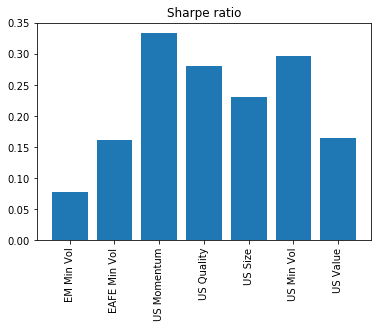

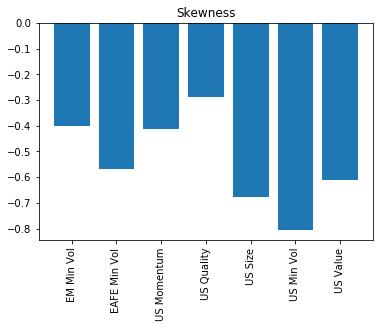

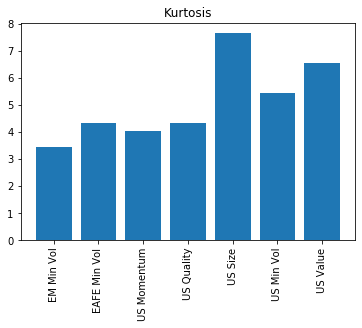

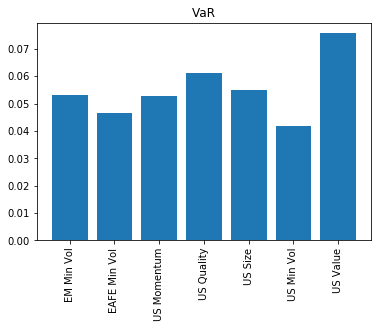

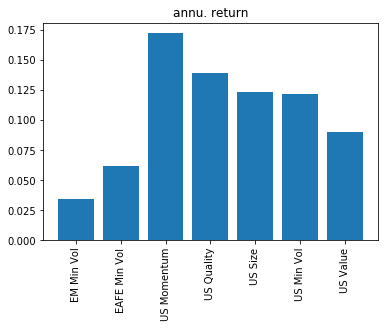

In [75]:
for i in range(0, len(l)):
    plt.figure()
    cri = l[i]
    plt.bar(factor_des.columns, factor_des.loc[cri])
    plt.title(f'{cri}')
    plt.xticks(rotation='vertical')

In [76]:
# create correlation matrix
def corr_map (df, fig=(10, 8), tittle='Pearson Correlation Matrix'):
    mask = np.zeros_like(df[df.columns].corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=fig)
    plt.title(tittle,fontsize=23)
    sns.heatmap(df[df.columns].corr(),linewidths=0.25, vmax=1.0, square=True, cmap="BuGn",
                linecolor='w', annot=True, mask=mask, cbar_kws={"shrink": .75})
    plt.savefig(f'{path}{tittle}')
    return f.tight_layout()

In [77]:
def merging_df (df1, df2):
    res = pd.merge(df1, df2, how='left', left_index=True, right_index=True)
    return res

---

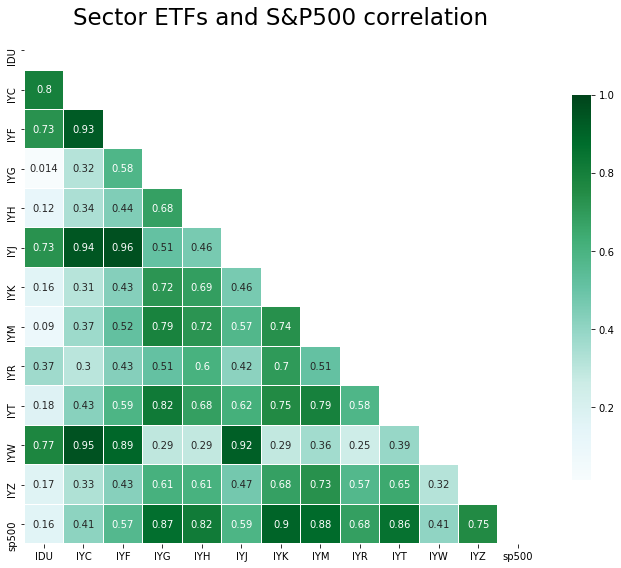

In [78]:
ind_sp500 = merging_df(ind, market_rf['sp500'])
ind_corr = corr_map(ind_sp500, tittle="Sector ETFs and S&P500 correlation")
ind_corr

The obvious observation from the correlation map above is that there were substantively positive correlations between S&P500 and sector ETFs (mostly around 0.6 to 0.8), except Utilities with 0.16. The highly correlated returns would potentially reduce the benefit of diversification across industries - especially when the market index performed poorly, which was the uttermost important element in considering this approach. Moreover, two highest correlations were detected between Industrials and Financials (0.96), trailed by Technology and Consumer (0.95). In contrast, Utilities and Financial Services had the lowest correlation (0.014), followed by Utilities and Materials (0.09).

---

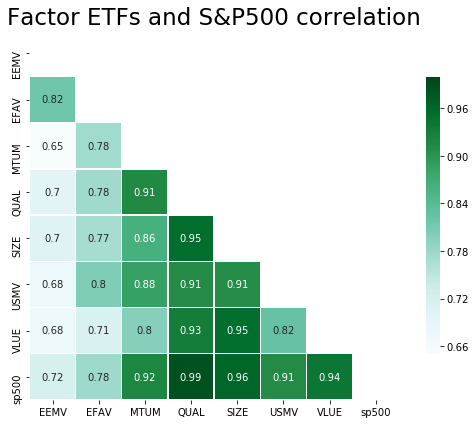

In [92]:
fac_sp500 = merging_df(factor, market_rf['sp500'])
fac_corr = corr_map(fac_sp500, fig=(8,6), tittle="Factor ETFs and S&P500 correlation")
fac_corr

All factor ETFs seemed to closely move with the S&P500 index (predominantly over 0.9), closely reached 1 for Quality and Size ETFs. Furthermore, correlations among factor ETFs also exhibited more homogeneous than that of sector ETFs. The lowest correlation was between the US Momentum ETF and the EM Min Vol (0.65), while the highest value (0.95) belonged to two pairs, specifically between the US Size ETF and the US Quality ETF, and the US Size ETF with the US Value ETF. Since the primary objective of these smart betas was to exploit mispricing that potentially appeared in the market, diversification benefit was understandably neglected.

In [91]:
fac_name

{'EEMV': 'EM Min Vol',
 'EFAV': 'EAFE Min Vol',
 'MTUM': 'US Momentum',
 'QUAL': 'US Quality',
 'SIZE': 'US Size',
 'USMV': 'US Min Vol',
 'VLUE': 'US Value'}